In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms

from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision.models import resnet18, resnet50

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pickle

C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [15]:
torch.manual_seed(159)

In [16]:
dataset_path = "./segmented_validation_set"

In [17]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])
test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

train_test_transform = {'train' : train_transform, 'test': test_transform}

In [18]:
testset = datasets.ImageFolder(dataset_path,       
                    transform=train_test_transform['test'])

In [19]:
def split_image_data(data_path, transform_dict):
    trainset = datasets.ImageFolder(data_path,       
                    transform=transform_dict['train'])
    testset = datasets.ImageFolder(data_path,       
                    transform=transform_dict['test'])
    
    num_test_imgs = int(np.floor(0.2 * len(trainset)))
    idx = list(range(len(trainset)))
    np.random.shuffle(idx)
    
    train_sampler = SubsetRandomSampler(idx[num_test_imgs:])
    test_sampler = SubsetRandomSampler(idx[:num_test_imgs])
    
    trainloader = DataLoader(trainset, sampler=train_sampler, batch_size=5)
    testloader = DataLoader(testset, sampler=test_sampler, batch_size=5)
    
    return trainloader, testloader

In [20]:
trainloader, testloader = split_image_data(dataset_path, train_test_transform)

In [21]:
len(testloader)

11

In [2]:
class_names = ['Healthy', 'Susceptible']

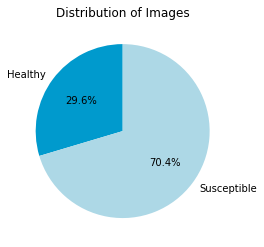

In [23]:
class_names = os.listdir(dataset_path)
image_count = {}
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(dataset_path,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
plt.title("Distribution of Images")
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=False,
        autopct = '%1.1f%%',
        startangle=90,
       colors=color_palette_list[0:3])
plt.show()

<AxesSubplot:title={'center':'Image count by type'}>

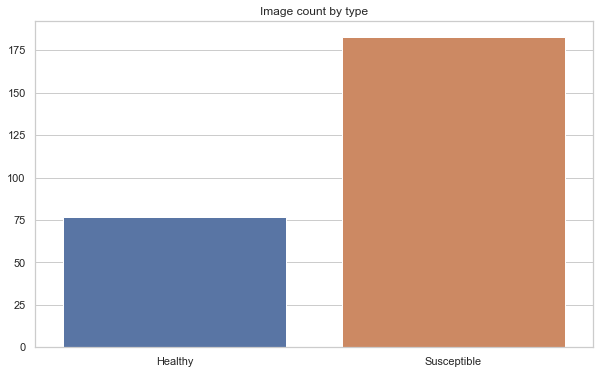

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
plt.title("Image count by type")
sns.barplot(x=list(image_count.keys()), y=list(image_count.values()))

In [8]:
model = resnet18(pretrained=True)

In [9]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
model.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
model.load_state_dict(torch.load("valid_segmented.pt"))

<All keys matched successfully>

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [27]:
def image_label_plotter(imgs, labels, output_pred):
    plt.figure(figsize=(8,6))
    for i, img in enumerate(imgs):
        plt.subplot(1, 5, i + 1, xticks = [], yticks =[]) 
        img = img.cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) #using mean and std
        img = np.clip(img, 0., 1.)
        plt.imshow(img)
        
        col = 'green' if output_pred[i] == labels[i] else 'red'
        xlabel = class_names[int(labels[i].cpu().numpy())]
        ylabel = class_names[int(output_pred[i].cpu().numpy())]
        plt.xlabel(xlabel)
        plt.ylabel(ylabel, color=col)
    plt.tight_layout()
    plt.show()

In [28]:
def display_prediction_images(testloader):
    model.eval() 
    imgs, labels = next(iter(testloader))
    if (torch.cuda.is_available()):
        imgs = imgs.cuda()
        labels = labels.cuda()
    outputs = model(imgs)
    _, output_pred = torch.max(outputs, 1)
    image_label_plotter(imgs, labels, output_pred)



C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


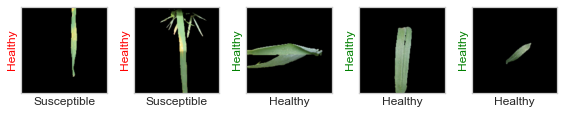

In [20]:
display_prediction_images(testloader)

In [23]:
def train_model(model, epochs, trainloader, testloader, optimizer, loss_fn):
    metrics = {'train_loss' : [], 
               'valid_loss' : [], 
               'train_accuracy' : [], 
               'valid_accuracy' : [], 
               'train_loss_all' : [], 
               'train_acc_all' : []}
    print("Training {} model".format(model.__class__.__name__))
    train_step = 0
    for e in range(0, epochs):
        print()
        print("Epoch {} of {}".format(e+1,epochs))

        train_loss = 0.
        val_loss = 0.  
        
        model.train()
        for batch_no, (images, labels) in enumerate(trainloader):
            if (torch.cuda.is_available()):
                images = images.cuda()
                labels = labels.cuda()
            train_step += 1
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward() #Back propogation
            optimizer.step() 
            train_loss += loss.item() 
            
            _, train_preds = torch.max(outputs, 1) 
            train_acc = sum((train_preds == labels).cpu().numpy())
            
            metrics['train_loss_all'].append(train_loss/(train_step+1))
            metrics['train_acc_all'].append(train_acc /(train_step+1))
            
            #Evaluating the model every 20th batch
            if batch_no % 10 == 0:
                metrics['train_loss'].append(train_loss/(train_step+1))
                metrics['train_accuracy'].append(train_acc/(train_step+1))
                print('Evaluating at Batch', batch_no)

                accuracy = 0

                model.eval()

                for val_step, (images, labels) in enumerate(testloader):
                    if (torch.cuda.is_available()):
                        images = images.cuda()
                        labels = labels.cuda()
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) 
                    accuracy += sum((preds == labels).cpu().numpy()) 

                val_loss /= (val_step + 1) 
                accuracy = accuracy/ (len(testset) / 5)
                print("Validation Loss: {:.4f}, Accuracy: {:.4f}".format(val_loss, accuracy))
                
                metrics['valid_loss'].append(val_loss)
                metrics['valid_accuracy'].append(accuracy)
                
                

                display_prediction_images(testloader)

                model.train()

                if accuracy >= 0.85:
                    
                    print('Optimal Accuracy Attained. Stopping now!')
                    train_loss /= (train_step + 1)
                    print("Training Loss {:.4f}".format(train_loss))
                    return metrics
    return metrics
        

Training ResNet model

Epoch 1 of 1
Evaluating at Batch 0
Validation Loss: 0.7711, Accuracy: 0.4808


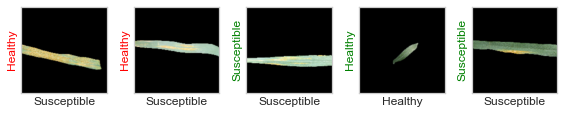

Evaluating at Batch 10
Validation Loss: 0.6972, Accuracy: 0.6538


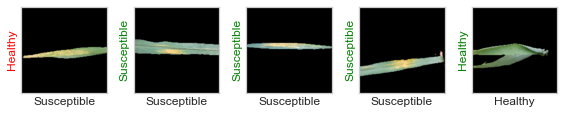

Evaluating at Batch 20
Validation Loss: 0.5786, Accuracy: 0.7885


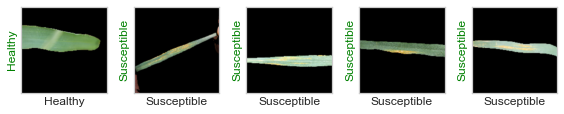

Evaluating at Batch 30
Validation Loss: 0.4660, Accuracy: 0.8462


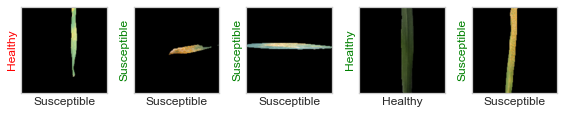

Evaluating at Batch 40
Validation Loss: 0.3641, Accuracy: 0.8846


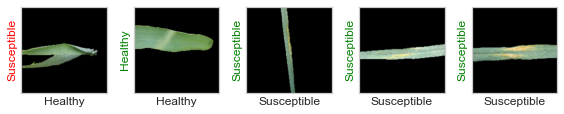

Optimal Accuracy Attained. Stopping now!
Training Loss 0.6158


In [24]:
metrics = train_model(model, 1, trainloader, testloader, optimizer, loss_fn)

In [27]:
torch.save(model.state_dict(), "valid_segmented.pt")

In [26]:
metrics

{'train_loss': [0.4497471749782562,
  0.7137569114565849,
  0.7499430138956417,
  0.6798431128263474,
  0.6158335953950882],
 'valid_loss': [0.7711031111803922,
  0.6971550310446211,
  0.5786120920903158,
  0.4660317507614391,
  0.3641101560559209],
 'train_accuracy': [1.0,
  0.4166666666666667,
  0.13636363636363635,
  0.15625,
  0.11904761904761904],
 'valid_accuracy': [0.4807692307692308,
  0.6538461538461539,
  0.7884615384615384,
  0.8461538461538461,
  0.8846153846153846],
 'train_loss_all': [0.4497471749782562,
  0.6636974215507507,
  0.6572406738996506,
  0.6215407848358154,
  0.6583612163861593,
  0.6596610120364598,
  0.6613156050443649,
  0.6635696093241373,
  0.70946124792099,
  0.7480930523438887,
  0.7137569114565849,
  0.6964879746620471,
  0.7106834032705852,
  0.6937822997570038,
  0.6796766724437475,
  0.6933937931762022,
  0.6983431163761351,
  0.7213122389818493,
  0.7414812311530113,
  0.7563253172806331,
  0.7499430138956417,
  0.7368433203386224,
  0.745109219104

In [26]:
with open('valid_segmented.obj', 'wb') as fp:
    pickle.dump(metrics, fp)

In [29]:
def test_model(testloader, model, loss_fn):
    print("Testing {} model".format(model.__class__.__name__))
    test_metrics = {'labels' : [], 
                    'predictions' :[]}
    test_loss = 0.
    correct = 0.
    total = 0.
    model.eval()
    for batch_idx, (images, target) in enumerate(testloader):
        if (torch.cuda.is_available()):
            images = images.cuda()
            target = target.cuda()
        test_metrics['labels'] += list(target)
        outputs = model(images)
        loss = loss_fn(outputs, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = outputs.data.max(1, keepdim=True)[1]
        
        test_metrics['predictions'] += list(pred)
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %.3f%% (%2d/%2d)' % (100. * correct / total, correct, total))
    return test_metrics

In [30]:
test_metrics = test_model(testloader, model, loss_fn)

Testing ResNet model


C:\Users\erudi\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test Loss: 0.252193


Test Accuracy: 92.308% (48/52)


In [31]:
with open('test_valid_segmented.obj', 'wb') as fp:
    pickle.dump(test_metrics, fp)

In [32]:
labs = [int(x) for x in test_metrics['labels']]
preds = [int(x) for x in test_metrics['predictions']]

In [35]:
with open('validation_segmented/labels.obj', 'wb') as fp:
    pickle.dump(labs, fp)
    
with open('validation_segmented/preds.obj', 'wb') as fp:
    pickle.dump(preds, fp)

In [3]:
with open('validation_segmented/labels.obj', 'rb') as f:
    labs = pickle.load(f)
    
with open('validation_segmented/preds.obj', 'rb') as f:
    preds = pickle.load(f)

In [4]:
accuracy_score(labs, preds)

0.9230769230769231

In [5]:
print(classification_report(labs, preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.90      0.95        40

    accuracy                           0.92        52
   macro avg       0.88      0.95      0.90        52
weighted avg       0.94      0.92      0.93        52



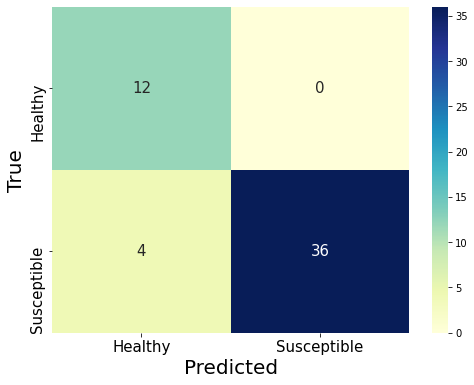

In [7]:
confusion_mat =  confusion_matrix(labs, preds)
plt.figure(figsize=(8,6))

ax= plt.subplot()
sns.heatmap(confusion_mat,cmap="YlGnBu", annot=True, fmt='g', ax=ax, annot_kws = {'size':15})

ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

#plt.title("Confusion Matrix for GrabCut Dataset", fontsize=20)
#plt.xticks([0,1,2],labels=class_names)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 

plt.savefig("validation_segmented/valid_seg_confusion.png")
plt.show()

In [4]:
metrics = {'train_loss': [0.4497471749782562,
  0.7137569114565849,
  0.7499430138956417,
  0.6798431128263474,
  0.6158335953950882],
 'valid_loss': [0.7711031111803922,
  0.6971550310446211,
  0.5786120920903158,
  0.4660317507614391,
  0.3641101560559209],
 'train_accuracy': [1.0,
  0.4166666666666667,
  0.13636363636363635,
  0.15625,
  0.11904761904761904],
 'valid_accuracy': [0.4807692307692308,
  0.6538461538461539,
  0.7884615384615384,
  0.8461538461538461,
  0.8846153846153846],
 'train_loss_all': [0.4497471749782562,
  0.6636974215507507,
  0.6572406738996506,
  0.6215407848358154,
  0.6583612163861593,
  0.6596610120364598,
  0.6613156050443649,
  0.6635696093241373,
  0.70946124792099,
  0.7480930523438887,
  0.7137569114565849,
  0.6964879746620471,
  0.7106834032705852,
  0.6937822997570038,
  0.6796766724437475,
  0.6933937931762022,
  0.6983431163761351,
  0.7213122389818493,
  0.7414812311530113,
  0.7563253172806331,
  0.7499430138956417,
  0.7368433203386224,
  0.7451092191040516,
  0.7262859070301055,
  0.719364807009697,
  0.7212454930499748,
  0.7159560482416835,
  0.7012901419195635,
  0.7050916562477748,
  0.6942686957697715,
  0.6798431128263474,
  0.6833648410710421,
  0.6896661221981049,
  0.6759576180151531,
  0.6703749733666579,
  0.6602803239145795,
  0.6563833728432655,
  0.6446155110994974,
  0.6326832316815854,
  0.6275976968974601,
  0.6158335953950882],
 'train_acc_all': [1.0,
  0.3333333333333333,
  0.75,
  0.8,
  0.5,
  0.42857142857142855,
  0.375,
  0.2222222222222222,
  0.0,
  0.09090909090909091,
  0.4166666666666667,
  0.3076923076923077,
  0.07142857142857142,
  0.26666666666666666,
  0.25,
  0.11764705882352941,
  0.1111111111111111,
  0.05263157894736842,
  0.1,
  0.047619047619047616,
  0.13636363636363635,
  0.13043478260869565,
  0.08333333333333333,
  0.2,
  0.15384615384615385,
  0.14814814814814814,
  0.14285714285714285,
  0.1724137931034483,
  0.1,
  0.12903225806451613,
  0.15625,
  0.06060606060606061,
  0.08823529411764706,
  0.14285714285714285,
  0.08333333333333333,
  0.13513513513513514,
  0.10526315789473684,
  0.1282051282051282,
  0.125,
  0.0975609756097561,
  0.11904761904761904]}

In [6]:
metrics['train_loss']

[0.4497471749782562,
 0.7137569114565849,
 0.7499430138956417,
 0.6798431128263474,
 0.6158335953950882]

In [8]:
precision_score(labs, preds, average='micro')

0.9230769230769231

In [9]:
recall_score(labs, preds, average='micro')

0.9230769230769231

In [10]:
f1_score(labs, preds, average='micro')

0.9230769230769231

In [52]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

In [43]:
fpr, tpr, thresholds = roc_curve(labs, preds)

In [46]:
roc_auc = auc(fpr, tpr)

In [50]:
import sklearn

<Figure size 864x576 with 0 Axes>

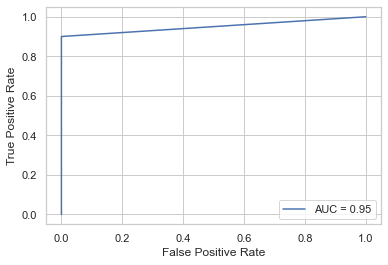

In [66]:
roc_fig = plt.figure(figsize=(12,8))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
#plt.figure(figsize=(12,8))
plt.savefig('validation_segmented/roc_plot.png')
plt.show()